# Bilevel Differential grasp planner

## Minimal Distance between two convex hulls
Two random point clouds are generated and their convex hulls are computed with scipy.spatial.ConvexHull. The minimal distance between them are optimized by QP solver in CVXPY

In [157]:
import numpy as np
import cvxpy as cp
from pypoman import compute_polytope_vertices, compute_polytope_halfspaces 
import plotly.graph_objects as go
import torch
import torch.nn as nn
pi = torch.acos(torch.zeros(1)).item() *2


In [158]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [159]:
points1 = np.random.rand(30, 3)
points2 = np.random.rand(30, 3) + 3

hull1 = ConvexHull(points1)
hull2 = ConvexHull(points2)
inpoint1 = points1[~hull1.vertices, :][0, :]
inpoint2 = points2[~hull2.vertices, :][0, :]


In [160]:
def get_feasible_region(hull):
    inpoint = hull.points[~hull.vertices, :][0, :]   
#     inpoints = inpoint * np.ones((hull.equations.shape[0], 3))
#     point_in_plane = np.zeros_like(inpoints)
#     point_in_plane[:, 2] = -hull.equations[:, 3] / hull.equations[:, 2]
#     vectors = inpoints - point_in_plane
#     negative = np.sum(np.multiply(vectors, hull.equations[:, :-1]), axis = 1)
    negative = hull.equations[:, :-1] @ inpoint + hull.equations[:, -1]
    return negative

print(get_feasible_region(hull1))

[-0.55807449 -0.04963278 -0.39877052 -0.67258888 -0.63347961 -0.85064798
 -0.41913355 -0.36428934 -0.21019674 -0.85110477 -0.61078152 -0.6824599
 -0.96155059 -0.04969621 -0.124958   -0.0523317  -0.22993994 -0.18565913
 -0.2216713  -0.30122617 -0.22806163 -0.28751321 -0.27898501 -0.94198782
 -0.93832117 -0.92203688 -0.86858543 -0.87742702  0.          0.
  0.          0.          0.          0.        ]


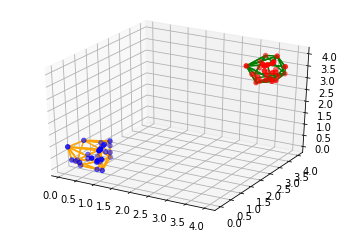

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(points1[:,0], points1[:,1], points1[:,2], c='blue')
for simplex1 in hull1.simplices:
    ax.plot3D(points1[simplex1, 0], points1[simplex1, 1], points1[simplex1, 2],  'orange')

ax.scatter3D(points2[:,0], points2[:,1], points2[:,2], c='red')
for simplex2 in hull2.simplices:
    ax.plot3D(points2[simplex2, 0], points2[simplex2, 1], points2[simplex2, 2] ,'green')

In [162]:
v1 = points1[hull1.vertices]
v2 = points2[hull2.vertices]

In [168]:
A1, b1 = compute_polytope_halfspaces(v1)
A2, b2 = compute_polytope_halfspaces(v2)

In [164]:
A1, b1 = hull1.equations[:, :-1], -hull1.equations[:, -1]
A2, b2 = hull2.equations[:, :-1], -hull2.equations[:, -1]

In [169]:
x1 = cp.Variable(3)
x2 = cp.Variable(3)

objective = cp.Minimize(cp.sum_squares(x1 - x2))
constraints = [A1 @ x1 <= b1, A2 @ x2 <= b2]
prob = cp.Problem(objective, constraints)
print("optimal value = ", prob.solve())
print("optimal x1 = ", x1.value)
print('optimal x2 = ', x2.value)
optimal_dots = np.array([x1.value, x2.value])

optimal value =  17.0030430728683
optimal x1 =  [0.78361967 0.85834712 0.96429818]
optimal x2 =  [3.43362493 3.23573585 3.04481203]


In [170]:
simplex1 = hull1.simplices
simplex2 = hull2.simplices
fig = go.Figure()
for i in range(simplex1.shape[0]):
    if i == 0:
        fig.add_trace(go.Mesh3d(x=points1[simplex1[i], 0],
                                y=points1[simplex1[i], 1],
                                z=points1[simplex1[i], 2],
                                color='lightpink',
                                opacity=0.5,
                                legendgroup='Convex Hull1',
                                name='Convex Hull1',
                                showlegend=True))
    else:
        fig.add_trace(go.Mesh3d(x=points1[simplex1[i], 0],
                                y=points1[simplex1[i], 1],
                                z=points1[simplex1[i], 2],
                                color='lightpink',
                                opacity=0.5,
                                legendgroup='Convex Hull1',
                                name='Convex Hull1',
                                showlegend=False))
    
for i in range(simplex2.shape[0]):
    if i == 0:
        fig.add_trace(go.Mesh3d(x=points2[simplex2[i], 0],
                                y=points2[simplex2[i], 1],
                                z=points2[simplex2[i], 2],
                                color='lightblue',
                                opacity=0.5,
                                legendgroup='Convex Hull2',
                                name='Convex Hull2',
                                showlegend=True))
    else:
        fig.add_trace(go.Mesh3d(x=points2[simplex2[i], 0],
                                y=points2[simplex2[i], 1],
                                z=points2[simplex2[i], 2],
                                color='lightblue',
                                opacity=0.5,
                                legendgroup='Convex Hull2',
                                name='Convex Hull2',
                                showlegend=False))

fig.add_trace(go.Scatter3d(x=optimal_dots[:, 0],
                           y=optimal_dots[:, 1],
                           z=optimal_dots[:, 2],
                           marker=dict(size=4,
                                       color='tomato',
                                       symbol='diamond'),
                           line=dict(color='tomato',
                                     width=4),
                           legendgroup="Smallest Distance",
                           name="Smallest Distance"))
fig.update_layout(scene_camera=dict(eye=dict(x=1.2, y=-1.6, z=1.0)), 
                  margin=dict(t=0, r=10, l=10, b=10),
                  legend=dict(x=0.6, y=1))
fig.show()

In [167]:
import plotly

# plotly.io.write_image(fig, r'../bilevel_figs/dist_of_convexhulls.png', scale = 10)

## Tuning Free Opimization

In [12]:
from LBFGS import LBFGS, FullBatchLBFGS

In [13]:
import torch 
from torch.optim import Optimizer

In [110]:
# initial guess of parameters
beta, phi = torch.Tensor([pi / 4]), torch.Tensor([pi / 4])
beta.requires_grad = True
phi.requires_grad = True

d = torch.Tensor([2]).requires_grad_(True)
theta = torch.Tensor([0.0]).requires_grad_(True)

# distance between two convex hulls
def distance_between_convex_hulls(A1, b1, A2, b2):
    x1 = cp.Variable(3)
    x2 = cp.Variable(3)

    objective = cp.Minimize(cp.sum_squares(x1 - x2))
    constraints = [A1 @ x1 <= b1, A2 @ x2 <= b2]
    prob = cp.Problem(objective, constraints)
    min_dist = prob.solve()
    return min_dist, x1.value, x2.value

# define objective function
def obj(beta, phi, theta, d, ch1, ch2):
    # unit vector expressed in sphere coordinates
    n = torch.Tensor([torch.cos(beta) * torch.cos(phi), torch.sin(beta) * torch.cos(phi), torch.sin(phi)]).reshape(1, 3).requires_grad_(True)
    # partial derivative of n with respect to beta
    pn_pbeta = torch.Tensor([-torch.sin(beta) * torch.cos(phi), torch.cos(beta) * torch.cos(phi), torch.sin(phi)]).reshape(3, 1)
    # partial derivative of n with respect to phi
    pn_pphi = torch.Tensor([-torch.cos(beta) * torch.sin(phi), -torch.sin(beta) * torch.sin(phi), torch.cos(phi)]).reshape(3, 1)
    # all the points contained in or on convex hulls
    points1 = torch.Tensor(ch1.points)
    points2 = torch.Tensor(ch2.points)
    # vertices of two convex hulls
    v1 = points1[ch1.vertices, :].T
    v2 = points2[ch2.vertices, :].T
    # value of objective function
    objective = torch.sum(torch.log(torch.matmul(n, v2) - d * torch.ones(1, v2.shape[1]))) + torch.sum(torch.log(d * torch.ones(1, v1.shape[1]) - torch.matmul(n, v1)))
    # The chain rule. Partial derivativ e of O with respect to n
    po_pn = torch.sum(v2/(n.mm(v2) - d), dim=1) - torch.sum(v1/(d - n.mm(v1)), dim=1)
    po_pn = po_pn.reshape(1, 3)
    # Partial derivative of O with respect to beta and phi
    po_pbeta = po_pn.mm(pn_pbeta)
    po_pphi = po_pn.mm(pn_pphi)
    # Partial derivative of O with respect to d
    po_pd = -torch.sum(1/(n.mm(v2) - d)) + torch.sum(1/(d - n.mm(v1)))
    
    return objective, po_pbeta, po_pphi, po_pd

In [111]:
result, _, _, pd = obj(beta, phi, theta, d, hull1, hull2)
result.backward()
print(d.grad)
print(pd)

tensor([11.3648])
tensor(11.3648, grad_fn=<AddBackward0>)


In [53]:
class Bilevel(Optimizer):
    def __init__(params, defaults):
        pass

In [54]:
hull1.vertices


array([ 0,  2,  3,  5,  6,  7,  8, 11, 12, 14, 15, 17, 22, 23, 24, 25, 27,
       28], dtype=int32)

In [114]:
import os,trimesh,trimesh.creation,copy,math,re,pickle,shutil,vtk,scipy,torch,transforms3d
from collections import defaultdict
import xml.etree.ElementTree as ET
import numpy as np
#import kornia
import torch.nn.functional as F
torch.set_default_dtype(torch.float64)


SyntaxError: invalid syntax (<ipython-input-115-0f19ce5e21b8>, line 1)